# Implémentation de l'algorithme de Longstaff-Schwartz pour un Put Bermudéen

## Introduction

Dans ce projet, nous mettons en œuvre l’algorithme de Longstaff-Schwartz pour l’évaluation d’une option de vente Bermudéenne . Ce type d’option permet une exécution à un ensemble discret de dates prédéfinies. Le sous-jacent suit une dynamique de type Black-Scholes, donnée par le processus de diffusion exponentielle :  
$$
S_t = x_0 e^{(r - \frac{\sigma^2}{2})t + \sigma W_t}
$$
où $W_t$ est un mouvement brownien standard, $r$ le taux d’intérêt, $\sigma$ la volatilité, et $x_0$ la valeur initiale de l’actif.  

Nous considérons une discrétisation du temps: $t_n = n \frac{T}{N}$ pour $n = 0, \dots, N$. Le payoff associé à l’exercice en $t_n$ est donné par :  
$$
Z_n =  (K - S_{t_n})_+
$$
où $K$ est le prix d'exercice de l’option.  

L’algorithme de Longstaff-Schwartz permet d’estimer les stratégies optimales d’exercice .  

Dans cette étude, nous implémentons cet algorithme avec les paramètres suivants :  
- **Taux d’intérêt** : $r = 0.1$  
- **Volatilité** : $\sigma = 0.25$  
- **Valeur initiale du sous-jacent** : $x_0 = 100$  
- **Prix d’exercice** : $K = 110$  
- **Nombre de dates d’exercice** : $N = 10$  
- **Horizon temporel** : $T = 1$  

Nous afficherons ensuite les fonctions de valeur $V_n$ et de continuation $C_n$ obtenues après l’apprentissage de l’algorithme à chaque temps d'exercice.
 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 100
params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7 }



In [8]:
#paramétres
r=0.1
sigma=0.25
x_0=100
K=110
N=10   
T=1
npaths=1000000
ts = np.linspace(0, T, N+1)

In [9]:
# Simulation Monte-Carlo du processus Black-Scholes

def blackscholes_mc(S, vol, r, ts, npaths):

    nsteps = len(ts) - 1
    ts = np.asfarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths)),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r)*ts)
    return paths

In [10]:
paths=blackscholes_mc(x_0, sigma, r, ts, npaths)

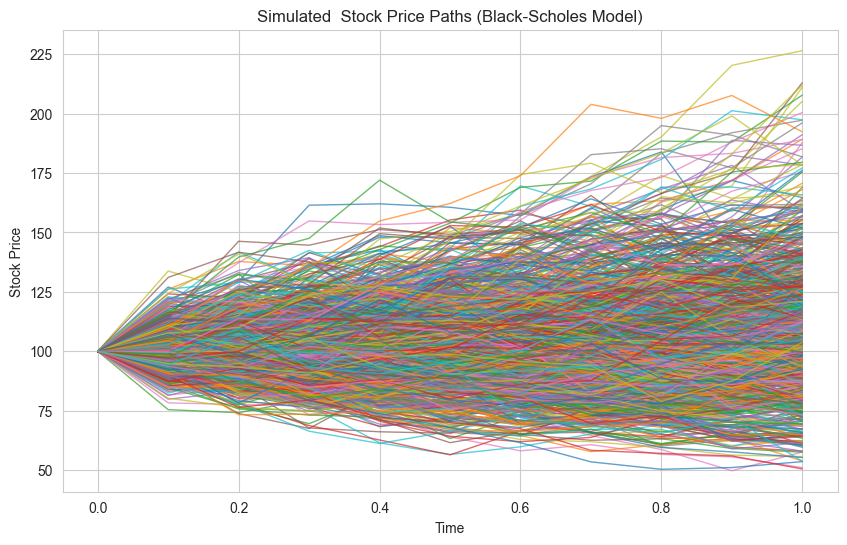

In [11]:
# Affichage de quelques trajectoires simulées
plt.figure(figsize=(10, 6))
for i in range(0,npaths,npaths//int(npaths/1000)):
    plt.plot(ts, paths[:, i], linewidth=1, alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title(f"Simulated  Stock Price Paths (Black-Scholes Model)")
plt.grid(True)
plt.show()

In [12]:
# Initialisation des matrices de stockage 
C = np.zeros((len(ts), npaths)) 
V = np.zeros((len(ts), npaths))
V[-1] = np.maximum(K - paths[-1], 0)
C[-1] = np.zeros(npaths)

payoff = V[-1].copy()

# Matrice pour stocker les coefficients du polynôme
poly_coeffs = np.zeros((len(ts) - 1, 4))  # 4 polynôme de degré 3


for i in range(len(ts) - 2, 0, -1):
    discount = np.exp(-r * (ts[i + 1] - ts[i]))
    payoff *= discount
    
    # Régression polynomiale
    p = np.polyfit(paths[i], payoff, deg=3)
    poly_coeffs[i] = p  
    contval = np.polyval(p, paths[i])  # Valeur de continuation
    exerval = np.maximum(K - paths[i], 0)  # Valeur d'exercice
    
    C[i] = contval
    V[i] = np.maximum(exerval, contval)
    
    # Identifier les chemins où il faut exercer
    ind = exerval > contval
    payoff[ind] = exerval[ind]


print("Valeur de l'option:",max(np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))),10)) # K-x_0=10
# Calcul de la valeur initiale de l'option
#option_value = np.mean(V[0])
#print( option_value)




Valeur de l'option: 11.885872361517997


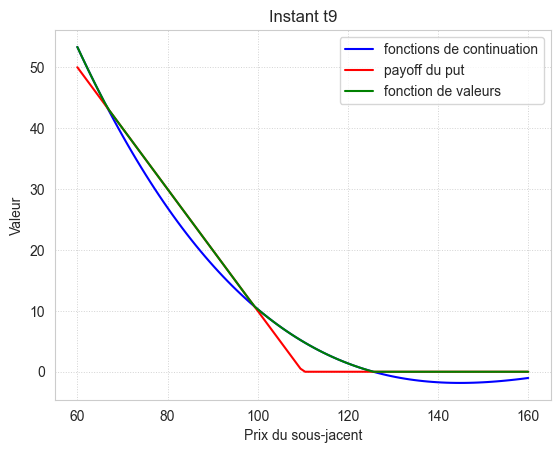

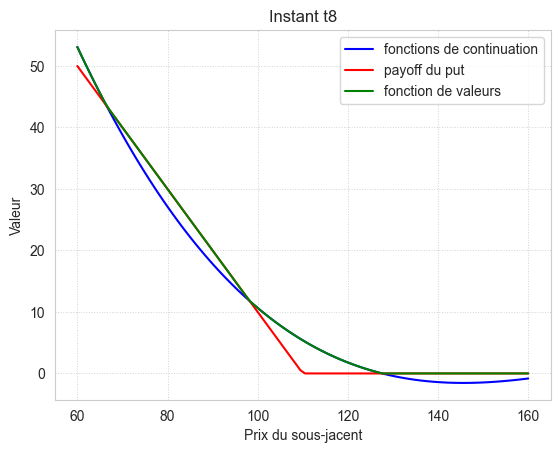

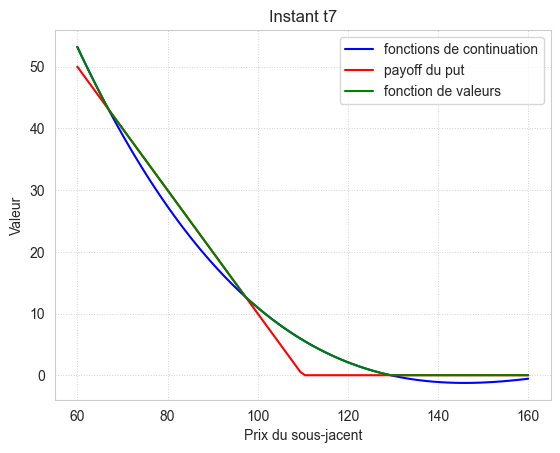

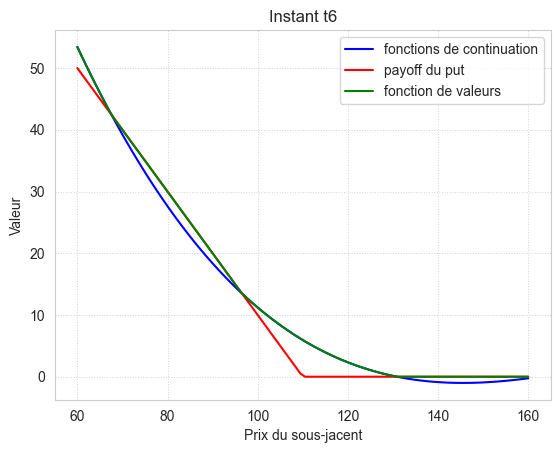

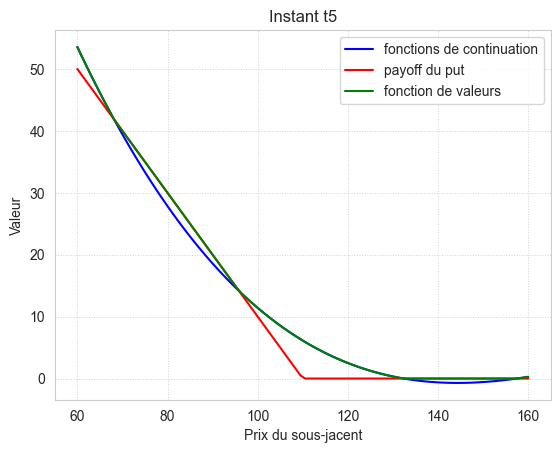

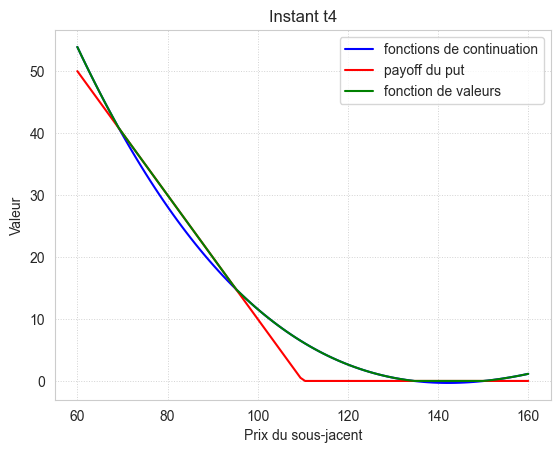

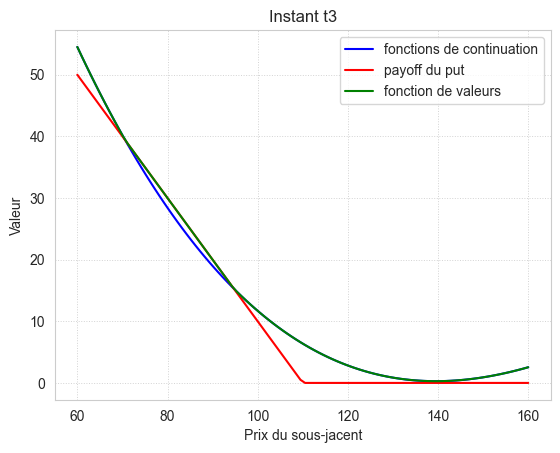

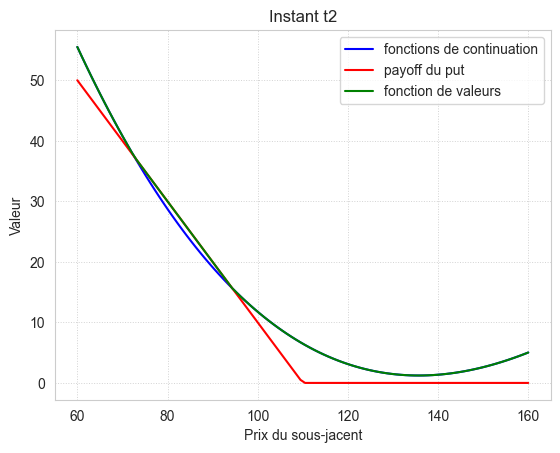

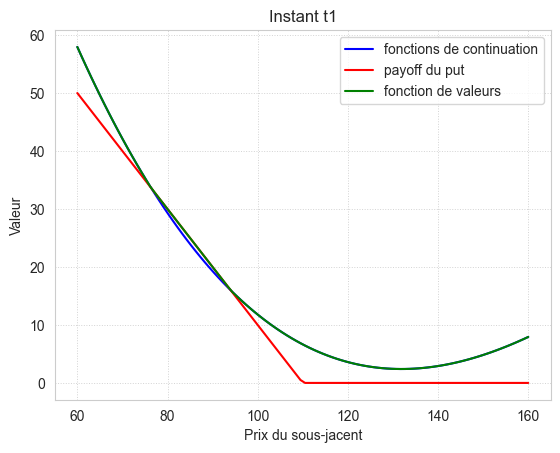

In [13]:
# Tracé 
x_vals = np.linspace(K-50, K+50, 100)
for i in range(len(ts) - 2, 0, -1): 
    plt.figure()
    plt.plot(x_vals, np.polyval(poly_coeffs[i], x_vals), label="fonctions de continuation", color='blue')
    plt.plot(x_vals, np.maximum(K - x_vals, 0), label="payoff du put", color='red')
    
    max_func = np.maximum(np.polyval(poly_coeffs[i], x_vals), np.maximum(K - x_vals, 0))
    plt.plot(x_vals, max_func, label="fonction de valeurs", color='green')
    
    plt.title(f'Instant t{i}')
    plt.xlabel("Prix du sous-jacent")
    plt.ylabel("Valeur")
    plt.legend()
    plt.grid(**params_grid)
    plt.show()
